# 0. Get some sample structure from KEGG

In [114]:
from bioservices.kegg import KEGG
k=KEGG()

# this script also uses Biopython and ProDy libraries

In [33]:
geneIdsInPathways = [ x.split()[0] for x in k.find("hsa", "p53").split("\n") if len(x.split()) > 0]
#geneIdsInPathways = geneIdsInPathways[:1]

In [35]:
#geneIdsInPathways=['hsa:3265']

In [119]:
pdbByGene = dict()
# for now store sequence information for gene in dictionary also
aaSeqByGene = dict()
for geneId in geneIdsInPathways:
    geneInfo = k.parse(k.get(geneId))
    if 'AASEQ' in geneInfo:
        aaSeqByGene[geneId] = geneInfo['AASEQ'].replace(' ', '') 
        # this might be empty, should show something in else clause
    if 'STRUCTURE' in geneInfo:
        pdbByGene[geneId] = geneInfo['STRUCTURE']['PDB'].split()

In [120]:
p53pdbIds = list(reduce(sum, map(set, pdbByGene.values()), set()))
p53pdbIds = ['2OSL']#p53pdbIds[:2]
p53pdbIds # for example, let's take the 1st one

# TODO: for simplicity, I decided to test on one multichain structure for now. to be fixed

['2OSL']

In [121]:
import os, prody
PDB_PATH = "pdb"
if not os.path.exists(PDB_PATH):
    os.mkdir(PDB_PATH)
    # TODO: for now I haven't checked if pathPDBFolder creates this folder - 
    # if it is created, this check should be removed.
prody.proteins.localpdb.pathPDBFolder(PDB_PATH)
# next - download all structures if they are not present and were not previously processed 

# all other checks are skipped now, will appear here later

downloadedPDBs = prody.proteins.localpdb.fetchPDB(p53pdbIds) # use filtered structures list
# TODO: some of PDB identifiers correspond to structures which has only .cif files. 
# in case if they are present we should check fetched PDB files and to store PDBIDs 
# which were not downloaded somewhere.


@> Local PDB folder is set: '/Users/lacemaker/github/biohack-2017/pdb'
INFO:.prody:Local PDB folder is set: '/Users/lacemaker/github/biohack-2017/pdb'
@> A plain folder structure will be assumed.
INFO:.prody:A plain folder structure will be assumed.
@> PDB file is found in the local folder (/Users/lacemaker/.../2osl.pdb.gz).
DEBUG:.prody:PDB file is found in the local folder (/Users/lacemaker/.../2osl.pdb.gz).


In [122]:
if isinstance(downloadedPDBs, str):
    downloadedPDBs = [downloadedPDBs] # this is to fix a library bug - 
    # when structure is found and there is only one, method returns <str> instead of [<str>]

In [123]:
d = ""
for downloadedPDB in filter(lambda x: x, downloadedPDBs):
    d = downloadedPDB
    pass

In [124]:
atoms, atoms_header = prody.parsePDB(d, header=True)

@> 7100 atoms and 1 coordinate set(s) were parsed in 0.07s.
DEBUG:.prody:7100 atoms and 1 coordinate set(s) were parsed in 0.07s.


In [146]:
from Bio.pairwise2 import *
from Bio.SubsMat import MatrixInfo as matlist
matrix = matlist.blosum62
    
def get_chain_score(refSequence, molecules):
    result = sorted([
        (align.globaldx(refSequence, p.sequence, matrix, score_only=True), 
         molecule_name, 
         p # or this can be p.chid - chain identifier
        )
        for molecule_name in molecules for p in molecules[molecule_name]
    ], reverse=True)
    # best possible molecule name at the beginning of the list
    return result[0][1:] # suppose there is at least 1 and return molecule name and polymer, without score
    


('HEAVY CHAIN OF THE RITUXIMAB FAB FRAGMENT',
 <Polymer: HEAVY CHAIN OF THE RITUXIMAB FAB FRAGMENT (2OSL_A)>)

In [155]:
# first group by polymer name
molecules = dict() # it doesn't guarantee anything, see 2OSL.pdb: heavy and light chains are actually 
# parts of the same antibody
# what about small molecules? for now let's ignore them
# 1. prepare - group by molecules
for polymer in atoms_header['polymers']:
    if not polymer.name in molecules:
        molecules[polymer.name] = []
    molecules[polymer.name].append(polymer)
    #print(polymer.chid, polymer.sequence, atoms[polymer.chid])
# 2. detect molecule with chain most similar to one corresponding to gene
(ref_molecule_name, ref_polymer) = get_chain_score(aaSeqByGene.values()[0], molecules)

In [156]:
# 3a.
ref_chain_atoms = atoms[ref_polymer.chid] # this atoms set correspond to chain we believe is a reference
chain2_atoms = None
# 3. iterate over other structures
for molecule_name in molecules:
    if molecule_name == ref_molecule_name:
        continue # skip chains with the same MOL_ID as in reference
    # iterate over chains in structures
    # there should be pickle save and load somewhere near this point
    for polymer in molecules[molecule_name]:
        chain2_atoms = atoms[polymer.chid]
        break
    print molecule_name
    break
# TODO: there might be 'SPLIT' in header. should check and save somewhere if this is present and process separately

B-LYMPHOCYTE ANTIGEN CD20


In [189]:
chain2_atoms # got this
ref_chain_atoms # and this
reference_contacts = Contacts(ref_chain_atoms)

In [190]:
# let's check: if there is one structure, in file there is no point to download this pdb file.

In [191]:
from prody import *

from pylab import *

ion()

In [225]:
distance_cutoff = 4 # TODO: this should be constant
ref_selection = reference_contacts.select(distance_cutoff, chain2_atoms)

In [226]:
repr(ref_selection) 
# TODO: next check getResindices, getResnames, or getResnums - see details here
# http://prody.csb.pitt.edu/manual/reference/atomic/selection.html#prody.atomic.selection.Selection

"<Selection: 'index 5157 to 5...21 to 5728 7070' from 2osl (41 atoms)>"

In [227]:
# pseudocode: for each Cys atom in selection: check atoms in ref and detect if Cys-Cys link is found.
# actually I don't know what to do with selenocysteine atoms? ignore or not?
# do we look for disulfide bonds? should check task description

In [228]:
# draw something (at least draw only part of the reference chain)
# see this http://prody.csb.pitt.edu/manual/reference/proteins/functions.html
# and this
# http://prody.csb.pitt.edu/manual/reference/atomic/selection.html

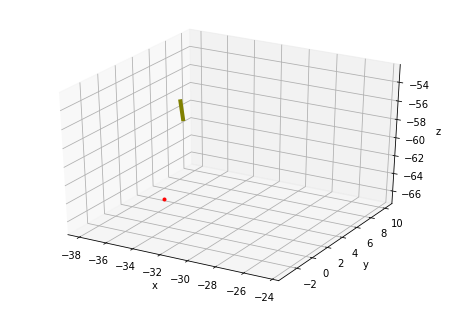

In [229]:
prody.proteins.functions.showProtein(ref_selection);
# something is drawn, as you can see at the picture below:

In [230]:
ref_selection.getResindices() # TODO: use this to make better picture

array([ 682,  682,  682,  684,  684,  696,  699,  699,  699,  700,  700,
        701,  701,  701,  701,  701,  704,  706,  706,  706,  706,  706,
        707,  707,  707,  708,  708,  708,  748,  748,  751,  751,  755,
        755,  755,  755,  755,  755,  755,  755, 1095])